In [1]:
import numpy as np
#
# The function in this file follow closely after the MATLAB scripts
# written by Alessandro Foi and Markku Makitalo - Tampere University
# of Technology - 2011-2012
#
#    http://www.cs.tut.fi/~foi/invansc/
#
# that accompanies their paper:
#
#    Reference: M. Makitalo and A. Foi, "Optimal inversion of the
#    generalized Anscombe transformation for Poisson-Gaussian noise",
#    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675


#-------- Variance stabilizing transforms -----------

def anscombe(x):
    '''
    Compute the anscombe variance stabilizing transform.
      the input   x   is noisy Poisson-distributed data
      the output  fx  has variance approximately equal to 1.
    Reference: Anscombe, F. J. (1948), "The transformation of Poisson,
    binomial and negative-binomial data", Biometrika 35 (3-4): 246-254
    '''
    return 2.0*np.sqrt(x + 3.0/8.0)

def inverse_anscombe(z):
    '''
    Compute the inverse transform using an approximation of the exact
    unbiased inverse.
    Reference: Makitalo, M., & Foi, A. (2011). A closed-form
    approximation of the exact unbiased inverse of the Anscombe
    variance-stabilizing transformation. Image Processing.
    '''
    #return (z/2.0)**2 - 3.0/8.0
    return (1.0/4.0 * np.power(z, 2) +
            1.0/4.0 * np.sqrt(3.0/2.0) * np.power(z, -1.0) -
            11.0/8.0 * np.power(z, -2.0) + 
            5.0/8.0 * np.sqrt(3.0/2.0) * np.power(z, -3.0) - 1.0 / 8.0)

def generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Compute the generalized anscombe variance stabilizing transform,
    which assumes that the data provided to it is a mixture of poisson
    and gaussian noise.
    The input signal  z  is assumed to follow the Poisson-Gaussian noise model
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    We assume that x contains only positive values.  Values that are
    less than or equal to 0 are ignored by the transform.
    Note, this transform will show some bias for counts less than
    about 20.
    '''
    y = gain*x + (gain**2)*3.0/8.0 + sigma**2 - gain*mu

    # Clamp to zero before taking the square root.
    return (2.0/gain)*np.sqrt(np.maximum(y, 0.0))

def inverse_generalized_anscombe(x, mu, sigma, gain=1.0):
    '''
    Applies the closed-form approximation of the exact unbiased
    inverse of Generalized Anscombe variance-stabilizing
    transformation.
    The input signal x is transform back into a Poisson random variable
    based on the assumption that the original signal from which it was
    derived follows the Poisson-Gaussian noise model:
        x = gain * p + n
    where gain is the camera gain and mu and sigma are the read noise
    mean and standard deviation.
    Roference: M. Makitalo and A. Foi, "Optimal inversion of the
    generalized Anscombe transformation for Poisson-Gaussian noise",
    IEEE Trans. Image Process., doi:10.1109/TIP.2012.2202675
    '''
    test = np.maximum(x, 1.0)
    exact_inverse = ( np.power(test/2.0, 2.0) +
                      1.0/4.0 * np.sqrt(3.0/2.0)*np.power(test, -1.0) -
                      11.0/8.0 * np.power(test, -2.0) +
                      5.0/8.0 * np.sqrt(3.0/2.0) * np.power(test, -3.0) -
                      1.0/8.0 - np.power(sigma, 2) )
    exact_inverse = np.maximum(0.0, exact_inverse)
    exact_inverse *= gain
    exact_inverse += mu
    exact_inverse[np.where(exact_inverse != exact_inverse)] = 0.0
    return exact_inverse

#def inverse_generalized_anscombe(y,mu,sigma,gain=1.0):
#    return (1.0/gain)*(gain*y/2.0)**2 - gain*3.0/8.0 - (sigma**2)/gain + mu

In [2]:
from bm3d import bm3d, BM3DProfile
import numpy as np
import scipy.misc
from matplotlib import pyplot as plt
from tifffile import imread, imsave

In [3]:
img = scipy.misc.ascent()
noise= np.random.randn(img.shape[0],img.shape[1])*30
imgNoisy=img+noise

In [16]:
noisy = imread('../../../experiments/fairSim/2020-07-27/Zeiss/p-3/Zeiss_Mito_600nm_crop_Poisson-n-3.tif').astype(np.float32)

clean = imread('../../../experiments/fairSim/2020-07-27/Zeiss/Zeiss_Mito_600nm_crop.tif').astype(np.float32)
print(noisy.shape)
print(clean.shape)


(5, 25, 512, 512)
(5, 25, 512, 512)


In [21]:
offset=100
from tqdm import tqdm
mses=[]
denoisedImgs=[]
bestMSE = None
bestImg = None
bestSig= None

for s in range(40):
    sig = (s+1)*2.5
    #denoised=noisy.copy()
    j=0
    #for i in range(5):
    i=0
#        print(i,j)

    img=noisy[i,j,...]
    cl= clean[i,j,...]

        
    ans=anscombe(img-offset)
    denoised = inverse_anscombe (bm3d (ans,sig)) + offset
    
        
    mse = np.mean((cl-denoised)**2)
    mses.append(mse)
    denoisedImgs.append(denoised.copy())
    
    if bestMSE is None or (mse<bestMSE):
        bestImg = denoised.copy()
        bestMSE = mse
        bestSig = sig
    print (sig, bestSig, mse)

        

2.5 2.5 613354.4641970571
5.0 2.5 1.3372148949636606e+19
7.5 2.5 2.783956130762644e+20
10.0 2.5 2.4044904844036874e+18
12.5 2.5 6188502846330750.0
15.0 2.5 14407290753.105803
17.5 17.5 66068.84803207744
20.0 20.0 44484.57595904867
22.5 22.5 35783.484515847136
25.0 25.0 33211.925647220356
27.5 27.5 32694.312336526058
30.0 27.5 32778.74932286069
32.5 27.5 33073.43273181036
35.0 27.5 33436.68714574272
37.5 27.5 33842.83099546325
40.0 27.5 34255.58867181636
42.5 27.5 34693.85856389813
45.0 27.5 35148.98989119905
47.5 27.5 35613.8147844572
50.0 27.5 36093.553534801875
52.5 27.5 36577.152239105606
55.0 27.5 37062.0560352418
57.5 27.5 37548.888453997155
60.0 27.5 38043.665363127046
62.5 27.5 38553.82135295709
65.0 27.5 39049.06243842308
67.5 27.5 39553.24197103663
70.0 27.5 40067.302474655604
72.5 27.5 40592.33189596671
75.0 27.5 41113.971131025995
77.5 27.5 41649.50782858255
80.0 27.5 42186.51304456323
82.5 27.5 42728.437136097826
85.0 27.5 43290.01050979012
87.5 27.5 43851.057953405965
90.0

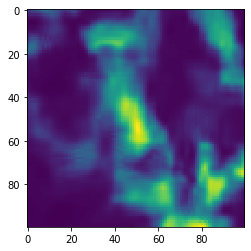

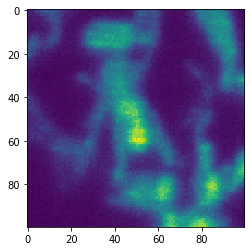

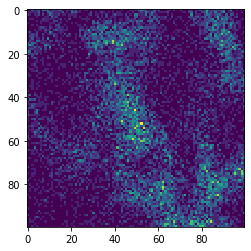

In [44]:
plt.imshow(denoisedImgs[11][100:200,100:200])
plt.show()
plt.imshow(cl[100:200,100:200])
plt.show()
plt.imshow(img[100:200,100:200])


In [46]:
offset=100
from tqdm import tqdm
denoised=noisy.copy()

for j in tqdm(range(25)):
    for i in range(5):
        img=noisy[i,j,...]
        cl= clean[i,j,...]

        sig = bestSig

        ans=anscombe(img-offset)
        denoisedImg = inverse_anscombe (bm3d (ans,sig)) + offset
        denoised[i,j,...] = denoisedImg
    


imsave('../../../experiments/fairSim/2020-07-27/Zeiss/p-3/n-3_VST-BM3D.tif', denoised)
        

100%|██████████| 25/25 [51:16<00:00, 123.07s/it]
